In [5]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

### Problem Description
#### Cat Breed Classification
This project focuses on developing a machine learning model capable of classifying images of cats into distinct breeds. The aim is to create an accurate and reliable model that can analyze an image and predict the cat's breed from a predefined list. This model has practical applications in various fields, including animal welfare, pet care, and digital content creation. By leveraging advanced image processing and machine learning techniques, this project demonstrates the potential of AI in enhancing our understanding and interaction with domestic animals.

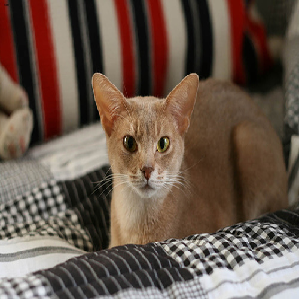

In [2]:
ds_path = '../dataset/data/Abyssinian'
name = 'Abyssinian_2.jpg'
fullname = ds_path + '/' + name
load_img(fullname, target_size=(299,299))

### Data Preparation and Splitting

This section involves a script for data preprocessing, specifically focusing on dividing the dataset into training and validation sets. The function split_data systematically processes each category within the dataset, segregating files into separate training and validation directories. This step is crucial for setting up a proper machine learning pipeline, ensuring that the model has distinct data for both training and validation phases.

In [3]:
def _copy_files(files, src_dir, dest_dir):
    os.makedirs(dest_dir, exist_ok=True)
    for file in files:
        src_path = os.path.join(src_dir, file)
        dest_path = os.path.join(dest_dir, file)
        shutil.copy(src_path, dest_path)


def split_data(source, dest):
    train_dir = f'{dest}/train'
    val_dir = f'{dest}/validation'
    
    for category in os.listdir(source):
        category_dir = os.path.join(source, category)
    
        if not os.path.isdir(category_dir):
            continue
        
        files = os.listdir(category_dir)
        train_files, val_files = train_test_split(files, test_size=0.2, random_state=42)
    
        _copy_files(train_files, category_dir, os.path.join(train_dir, category))
        _copy_files(val_files, category_dir, os.path.join(val_dir, category))

### Model Architecture and Compilation

Here, the notebook details the construction of a convolutional neural network using TensorFlow and Keras. The function make_model creates a model based on the Xception architecture, augmented with layers for pooling, normalization, dropout, and dense layers for classification. Parameters like learning rate, dropout rate, and L2 regularization rate are configurable. This function is key to experimenting with different model configurations and understanding their impact on training performance.

In [2]:
def make_model(learning_rate=0.001, droprate=0.0, l2_rate=0.0, output_nodes=20):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3),
    )
    inputs = keras.Input(shape=(150, 150, 3))
    
    base = base_model(inputs)
    vector = GlobalAveragePooling2D()(base)
    inner = Dense(128, activation='relu', kernel_regularizer=l2(l2_rate))(vector)
    normalization = BatchNormalization()(inner)
    drop = Dropout(droprate)(normalization)
    outputs = Dense(output_nodes, activation='softmax')(drop)
    
    model = keras.Model(inputs, outputs)

    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate)
    loss = keras.losses.CategoricalCrossentropy()
    
    model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
    
    return model

### Data Loading and Image Data Generator Setup

This section demonstrates the process of loading the dataset and preparing it for training and validation. The dataset is split into training and validation sets, ensuring a proper distribution of data for model training and evaluation.

In [8]:
split_data('../dataset/data', '../dataset/data_splitted')

The ImageDataGenerator is used for real-time data augmentation and preprocessing. This setup facilitates efficient training and validation with batch processing.

In [10]:
image_size = (150, 150)
batch_size = 32

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_ds = train_gen.flow_from_directory(
    "../dataset/data_splitted/train",
    target_size=image_size,
    batch_size=batch_size,
)

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_ds = val_gen.flow_from_directory(
    "../dataset/data_splitted/validation",
    target_size=image_size,
    batch_size=batch_size,
)

Found 5600 images belonging to 20 classes.
Found 1400 images belonging to 20 classes.


# Impact of Learning Rate on CNN Training Dynamics

This section delves into the effects of various learning rates on a convolutional neural network's training process. It methodically documents the training outcomes using learning rates 0.001, 0.0005, 0.0001, and 0.00005, over a span of 10 epochs. The focus is on observing variations in accuracy and loss, offering insights into how different learning rates can influence the model's learning trajectory and overall performance. This step is integral in pinpointing an effective learning rate for optimal training results.

In [13]:
lr_history = {}
learning_rates = [0.001, 0.0005, 0.0001, 0.00005]
for learning_rate in learning_rates:
    print(f'learning_rate: {learning_rate}')
    model = make_model(learning_rate=learning_rate, droprate=0, l2_rate=0)
    lr_history[learning_rate]= model.fit(train_ds, epochs=10, validation_data=val_ds)

learning_rate: 0.001
Epoch 1/10
175/175 [==============================] - 108s 488ms/step - loss: 1.7744 - accuracy: 0.4680 - val_loss: 2.4176 - val_accuracy: 0.3829
Epoch 2/10
175/175 [==============================] - 75s 424ms/step - loss: 0.9683 - accuracy: 0.6996 - val_loss: 1.6935 - val_accuracy: 0.5414
Epoch 3/10
175/175 [==============================] - 74s 424ms/step - loss: 0.6324 - accuracy: 0.8029 - val_loss: 1.7283 - val_accuracy: 0.5914
Epoch 4/10
175/175 [==============================] - 74s 424ms/step - loss: 0.4406 - accuracy: 0.8659 - val_loss: 1.9129 - val_accuracy: 0.5293
Epoch 5/10
175/175 [==============================] - 75s 425ms/step - loss: 0.3465 - accuracy: 0.8920 - val_loss: 2.1731 - val_accuracy: 0.5086
Epoch 6/10
175/175 [==============================] - 75s 426ms/step - loss: 0.3011 - accuracy: 0.9023 - val_loss: 1.6046 - val_accuracy: 0.5850
Epoch 7/10
175/175 [==============================] - 74s 424ms/step - loss: 0.1998 - accuracy: 0.9375 - val

In [13]:
def plot_learning_curves(history, keys, metric):
    plt.figure(figsize=(10, 6))
    for key in keys:
        plt.plot(history[key].history[f'val_{metric}'], label=f'{key} val_{metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

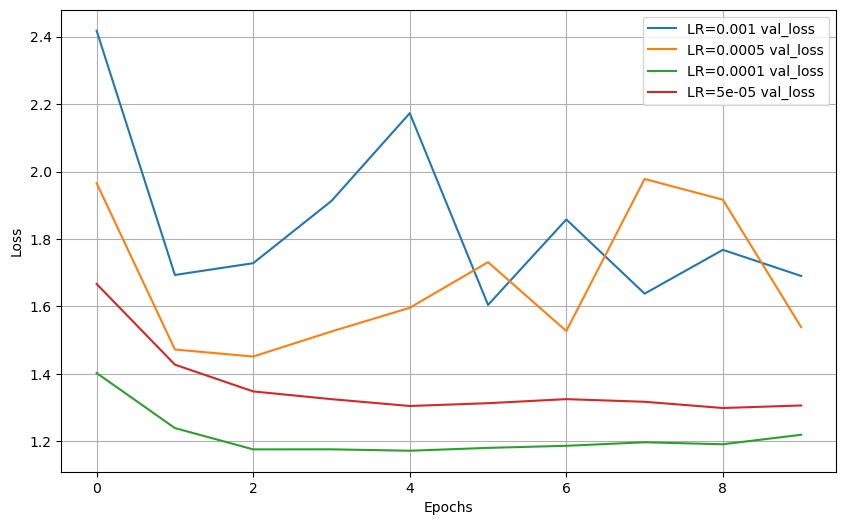

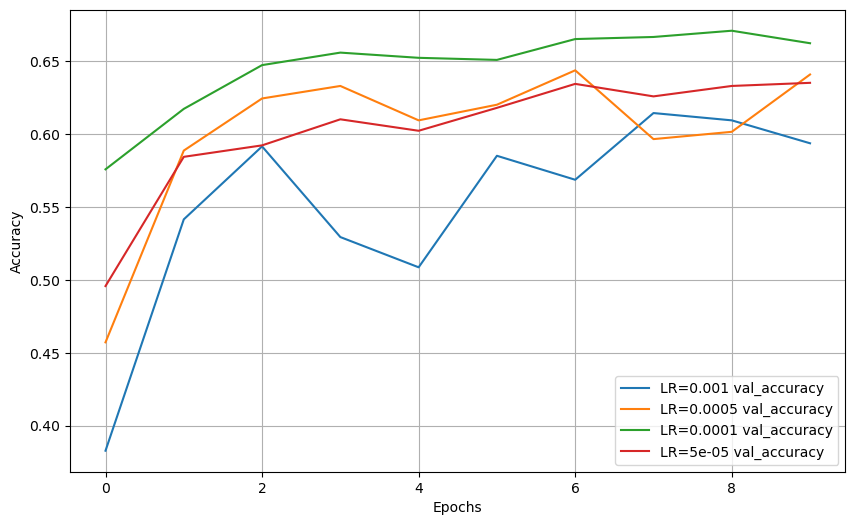

In [15]:
plot_learning_curves(lr_history, learning_rates, 'loss')
plot_learning_curves(lr_history, learning_rates, 'accuracy')

The experimental results from varying learning rates (0.001, 0.0005, 0.0001, and 0.00005) on CNN training reveal insightful patterns in model performance. At higher learning rates (0.001 and 0.0005), the model initially shows rapid improvements in accuracy but later faces challenges in validation accuracy, indicating potential overfitting. Lower learning rates (0.0001 and 0.00005) demonstrate a more consistent increase in validation accuracy, suggesting better generalization. These findings highlight the delicate balance in choosing an optimal learning rate, impacting both the speed of learning and the model's ability to generalize to unseen data.

### Exploring Dropout Rates in CNN

This part of the Jupyter notebook explores the impact of different dropout rates on the Convolutional Neural Network's performance. Three dropout rates (0.25, 0.5, 0.75) are tested to understand their influence on the model's ability to generalize and prevent overfitting.

In [16]:
dr_history = {}
droprates = [0.25, 0.5, 0.75]
for droprate in droprates:
    print(f'droprate: {droprate}')
    model = make_model(learning_rate=0.0001, droprate=droprate, l2_rate=0)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    dr_history[droprate]= model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[early_stopping])

droprate: 0.25
Epoch 1/10
175/175 [==============================] - 116s 516ms/step - loss: 2.2589 - accuracy: 0.3534 - val_loss: 1.4426 - val_accuracy: 0.5500
Epoch 2/10
175/175 [==============================] - 75s 427ms/step - loss: 1.0237 - accuracy: 0.6814 - val_loss: 1.2401 - val_accuracy: 0.6200
Epoch 3/10
175/175 [==============================] - 76s 435ms/step - loss: 0.5090 - accuracy: 0.8546 - val_loss: 1.1919 - val_accuracy: 0.6479
Epoch 4/10
175/175 [==============================] - 76s 434ms/step - loss: 0.2423 - accuracy: 0.9448 - val_loss: 1.1648 - val_accuracy: 0.6664
Epoch 5/10
175/175 [==============================] - 76s 433ms/step - loss: 0.1205 - accuracy: 0.9807 - val_loss: 1.1825 - val_accuracy: 0.6729
Epoch 6/10
175/175 [==============================] - 76s 432ms/step - loss: 0.0672 - accuracy: 0.9936 - val_loss: 1.1810 - val_accuracy: 0.6750
Epoch 7/10
175/175 [==============================] - 76s 431ms/step - loss: 0.0472 - accuracy: 0.9948 - val_loss:

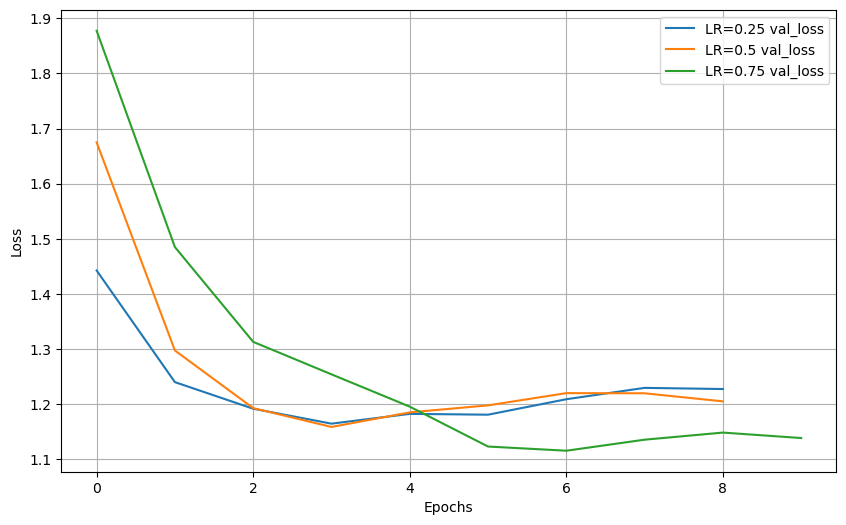

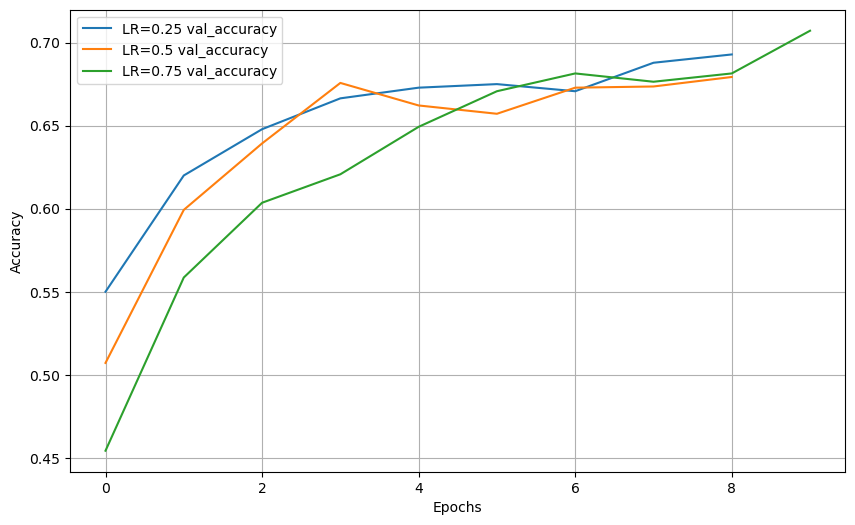

In [17]:
plot_learning_curves(dr_history, droprates, 'loss')
plot_learning_curves(dr_history, droprates, 'accuracy')

* Dropout 0.25: Achieved steadily increasing validation accuracy, peaking at 69.29%.
* Dropout 0.5: Slightly lower performance compared to 0.25 dropout, but still robust, with a top validation accuracy of 67.93%.
* Dropout 0.75: Demonstrated the importance of dropout in controlling overfitting, reaching a high validation accuracy of 70.71%.

#### Conclusion:
The experiments indicate that higher dropout rates can be beneficial for this specific model and dataset, enhancing the model's generalizability and reducing overfitting. The final choice of dropout rate should balance between retaining model complexity and preventing overfitting.

### Exploring Data Augmentation and L2 Regularization
#### Data Augmentation and Model Adjustments
* Introduced data augmentation techniques like rotation, shift, shear, zoom, flip, and brightness adjustments.

#### Adjusted the model by adding L2 regularization to mitigate overfitting.
* Experimenting with L2 Regularization Rates
* Tested L2 rates: 0.1, 0.01, and 0.001.
* Observed model performance across 15 epochs for each L2 rate.
* Monitored validation loss and accuracy to gauge the impact of L2 regularization.

In [11]:
train_gen_ag = ImageDataGenerator(
    rotation_range=4|0,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2),
    preprocessing_function=preprocess_input
)

train_ds_ag = train_gen_ag.flow_from_directory(
    "../dataset/data_splitted/train",
    target_size=image_size,
    batch_size=batch_size,
)

Found 5600 images belonging to 20 classes.


In [12]:
l2_history = {}
l2_rates = [0.1, 0.01, 0.001]
for l2_rate in l2_rates:
    print(f'l2_rate: {l2_rate}')
    model = make_model(learning_rate=0.0001, droprate=0.75, l2_rate=l2_rate)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    l2_history[l2_rate]= model.fit(train_ds_ag, epochs=15, validation_data=val_ds, callbacks=[early_stopping])

l2_rate: 0.1
Epoch 1/15


2023-12-20 15:11:14.563205: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


175/175 [==============================] - 136s 607ms/step - loss: 24.6877 - accuracy: 0.1459 - val_loss: 19.6822 - val_accuracy: 0.3879
Epoch 2/15
175/175 [==============================] - 88s 500ms/step - loss: 17.4913 - accuracy: 0.3002 - val_loss: 13.9825 - val_accuracy: 0.5207
Epoch 3/15
175/175 [==============================] - 89s 505ms/step - loss: 12.4190 - accuracy: 0.4155 - val_loss: 9.8119 - val_accuracy: 0.5907
Epoch 4/15
175/175 [==============================] - 90s 513ms/step - loss: 8.7565 - accuracy: 0.4993 - val_loss: 6.9348 - val_accuracy: 0.6257
Epoch 5/15
175/175 [==============================] - 90s 511ms/step - loss: 6.1659 - accuracy: 0.5688 - val_loss: 4.9343 - val_accuracy: 0.6493
Epoch 6/15
175/175 [==============================] - 91s 520ms/step - loss: 4.4260 - accuracy: 0.6175 - val_loss: 3.6154 - val_accuracy: 0.6971
Epoch 7/15
175/175 [==============================] - 88s 504ms/step - loss: 3.2512 - accuracy: 0.6543 - val_loss: 2.6987 - val_accurac

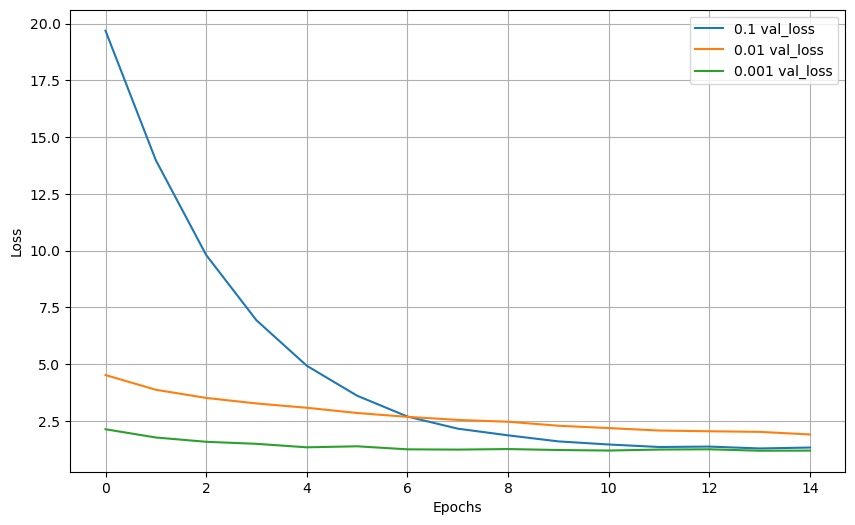

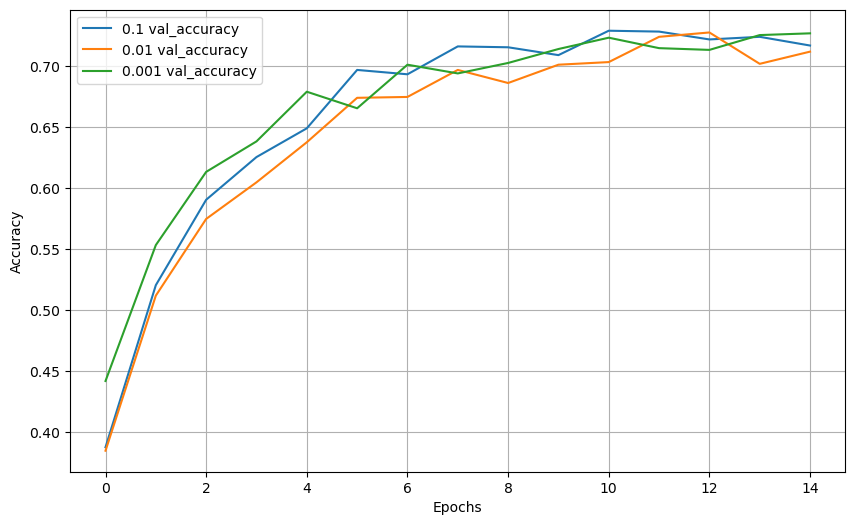

In [14]:
plot_learning_curves(l2_history, l2_rates, 'loss')
plot_learning_curves(l2_history, l2_rates, 'accuracy')

* The addition of data augmentation and L2 regularization significantly impacted the model's ability to generalize.
* Higher L2 rates initially showed improved validation accuracy but tended to over-regularize with prolonged training.
* Optimal L2 rate selection is crucial for balancing model complexity and performance.
* Visualizations of training and validation metrics aided in understanding the effects of these changes.

### Dataset Cleaning and Further Model Optimization
#### Cleaning the Dataset
* Undertook the process of cleaning the dataset to remove low-quality and incorrect images.
* Utilized a newly cleaned dataset for model training and validation.
#### Model Training with Cleaned Dataset
* Adjusted the model with the optimal parameters previously determined (learning rate: 0.0001, droprate: 0.75, L2 rate: 0.001).
* Conducted training over 15 epochs using the cleaned dataset.

In [15]:
split_data('../dataset/cleaned', '../dataset/cleaned_splitted')

In [16]:
train_ds_cleaned = train_gen_ag.flow_from_directory(
    "../dataset/cleaned_splitted/train",
    target_size=image_size,
    batch_size=batch_size,
)

val_gen_cleaned = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_ds_cleaned = val_gen_cleaned.flow_from_directory(
    "../dataset/cleaned_splitted/validation",
    target_size=image_size,
    batch_size=batch_size,
)

Found 5065 images belonging to 20 classes.
Found 1279 images belonging to 20 classes.


In [17]:
model = make_model(learning_rate=0.0001, droprate=0.75, l2_rate=0.001)
cleaned_history = model.fit(train_ds_cleaned, epochs=15, validation_data=val_ds_cleaned)

Epoch 1/15
159/159 [==============================] - 133s 691ms/step - loss: 4.0685 - accuracy: 0.1716 - val_loss: 2.4262 - val_accuracy: 0.3839
Epoch 2/15
159/159 [==============================] - 77s 483ms/step - loss: 2.6692 - accuracy: 0.3502 - val_loss: 1.8293 - val_accuracy: 0.5637
Epoch 3/15
159/159 [==============================] - 73s 460ms/step - loss: 2.1740 - accuracy: 0.4590 - val_loss: 1.5074 - val_accuracy: 0.6161
Epoch 4/15
159/159 [==============================] - 73s 461ms/step - loss: 1.8417 - accuracy: 0.5386 - val_loss: 1.3609 - val_accuracy: 0.6701
Epoch 5/15
159/159 [==============================] - 74s 464ms/step - loss: 1.6008 - accuracy: 0.5970 - val_loss: 1.2232 - val_accuracy: 0.7099
Epoch 6/15
159/159 [==============================] - 73s 461ms/step - loss: 1.4252 - accuracy: 0.6537 - val_loss: 1.2034 - val_accuracy: 0.7029
Epoch 7/15
159/159 [==============================] - 73s 461ms/step - loss: 1.3175 - accuracy: 0.6802 - val_loss: 1.1322 - val_a

In [29]:
def plot(history, param):
    plt.plot(history.history[param], label=param)
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

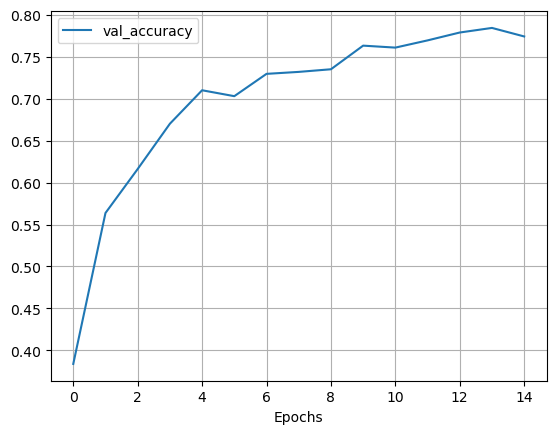

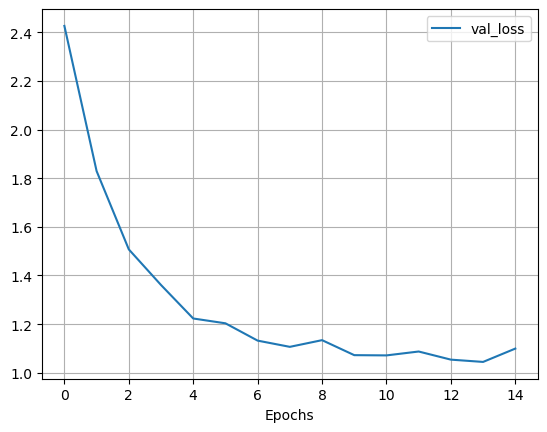

In [30]:
plot(cleaned_history, 'val_accuracy')
plot(cleaned_history, 'val_loss')

* Significant improvements in model accuracy and validation performance were observed with the cleaned dataset.
* Model achieved a more consistent and higher accuracy, indicating the effectiveness of dataset cleaning.
* Visualized training and validation metrics to analyze the impact of dataset cleaning on model performance.

This step demonstrated the importance of dataset quality in model training and the positive impact of careful data preprocessing.

### Reducing Dataset Classes and Saving Best Model
#### Dataset Modification
* Reduced the number of classes in the dataset by half to improve model performance.
* Focused on optimizing the model with this revised, more manageable dataset.
#### Model Training with Revised Dataset
* Trained the model on the modified dataset with the best parameters identified from previous iterations (learning rate: 0.0001, droprate: 0.75, L2 rate: 0.001).
* Implemented a checkpoint to save the best model based on validation accuracy.

In [21]:
split_data('../dataset/lite', '../dataset/lite_splitted')

In [22]:
train_ds_lite = train_gen_ag.flow_from_directory(
    "../dataset/lite_splitted/train",
    target_size=image_size,
    batch_size=batch_size,
)

val_gen_lite = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_ds_lite = val_gen_lite.flow_from_directory(
    "../dataset/lite_splitted/validation",
    target_size=image_size,
    batch_size=batch_size,
)

Found 2508 images belonging to 10 classes.
Found 634 images belonging to 10 classes.


In [26]:
checkpoint = keras.callbacks.ModelCheckpoint(
    "../models/cats_{epoch:02d}_{val_accuracy:.3f}.h5",
    save_best_only=True,
    monitor="val_accuracy"
)

model = make_model(learning_rate=0.0001, droprate=0.75, l2_rate=0.001, output_nodes=train_ds_lite.num_classes)
lite_history = model.fit(train_ds_lite, epochs=15, validation_data=val_ds_lite, callbacks=[checkpoint])

Epoch 1/15
79/79 [==============================] - 110s 977ms/step - loss: 3.3656 - accuracy: 0.2456 - val_loss: 1.4798 - val_accuracy: 0.5852
Epoch 2/15
79/79 [==============================] - 39s 491ms/step - loss: 1.9706 - accuracy: 0.4932 - val_loss: 1.1309 - val_accuracy: 0.7192
Epoch 3/15
79/79 [==============================] - 38s 482ms/step - loss: 1.5053 - accuracy: 0.6085 - val_loss: 1.0111 - val_accuracy: 0.7524
Epoch 4/15
79/79 [==============================] - 38s 476ms/step - loss: 1.2231 - accuracy: 0.6922 - val_loss: 0.9301 - val_accuracy: 0.7776
Epoch 5/15
79/79 [==============================] - 38s 474ms/step - loss: 1.0755 - accuracy: 0.7301 - val_loss: 0.8601 - val_accuracy: 0.8013
Epoch 6/15
79/79 [==============================] - 38s 477ms/step - loss: 0.9868 - accuracy: 0.7528 - val_loss: 0.8077 - val_accuracy: 0.8170
Epoch 7/15
79/79 [==============================] - 38s 483ms/step - loss: 0.8452 - accuracy: 0.8010 - val_loss: 0.7969 - val_accuracy: 0.820

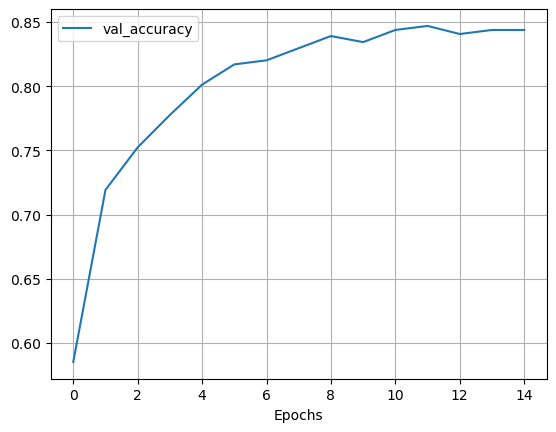

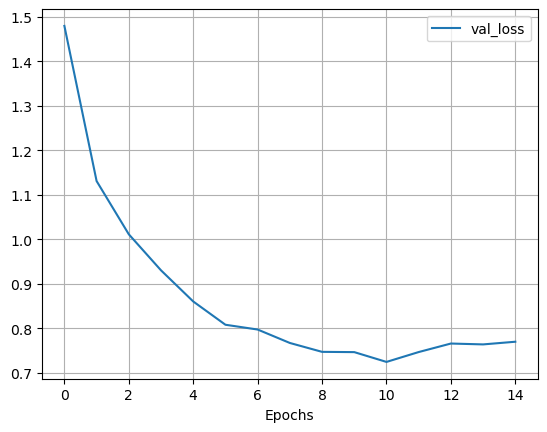

In [31]:
plot(lite_history, 'val_accuracy')
plot(lite_history, 'val_loss')

* Notable improvement in model accuracy, with validation accuracy nearing 85%.
* The strategy of reducing the number of classes proved effective in enhancing model performance.
* Utilized model checkpoints to save the best performing models for future use or deployment.

This step highlights the impact of dataset complexity on model performance and the benefits of strategic dataset adjustments.

### Summary

This project involved iterative improvements of a deep learning model for image classification. Starting with a basic model, various techniques like adjusting learning rates, droprates, and L2 regularization were explored. Data augmentation and dataset cleaning were implemented to enhance model training. A significant step was the reduction of dataset classes, leading to a more focused and efficient model. This process, along with saving the best models through checkpoints, culminated in achieving a notable improvement in accuracy. The journey highlights the importance of fine-tuning model parameters and strategically modifying datasets for optimal performance.